<img style="float:left" width="70%" src="pics/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="15%" src="pics/PythonLogo.svg">
<br style="clear:both;">

<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">Segmentación de imágenes RGB por agrupamiento</h2>

<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: red; line-height: 1.3em; color: white; border-radius: 10px;">Implementación de FCM, y una versión con incorporación de información espacial</h2>

### *Fuzzy C-Means* (FCM) y *Spatial Fuzzy C-Means* (sFCM)
#### Author: Pedro Latorre Carmona
#### Curso: 2025-2026
#### Alumno: Pablo Fernández Gumiel

Versión 1.0

---

En esta práctica, vais a:

1. <span style="color:red">**Implementar FCM desde cero**</span>


2. <span style="color:red">**Implementar una versión de FCM, sobre la que habráis creado en 1), que incluya también información espacial**</span> de una vecindad de ella. Por ejemplo, de $3\times3$, o de $5\times5$.


- La versión espacial de FCM la tenéis explicada en la Sección **III.B** del artículo cuyo **PDF** se os proporciona, también.


- En ambos casos, se ha de considerar el caso de imágenes en color.


- Se os da una imagen en color, sobre la que añadiréis ruido de tipo Gausiano.

---
### Incorporación de ruido *Gausiano*

Sobre la imagen en color que se os da, tendréis que introducir ruido Gausiano, de media cero y una determinada desviación estándar, i. e., $N(0,\sigma)$. 

Lo tendréis que hacer **por cada canal de color**, creando la imagen RGB ruidosa, correspondiente.


---
### Fuzzy C-Means

El procedimiento general de los algoritmos Fuzzy c-Means puede formalizarse en los siguientes pasos:

1. Fijar $c$ y $m$. 

2. Elegir aleatoriamente los centroides.

3. Calcular la matriz de partición difusa inicial $U^{(0)}$ = $[u_{ik}]^{(0)}$, siguiendo la ecuación:

$u_{ik}^{(0)}=\left(\sum \limits _{j=1}^{c}\left[{\frac {d_{ik}^{(0)}}{d_{jk}^{(0)}}}\right]^{\frac {2}{m-1}}\right)^{-1};1\leq k\leq n;1\leq i\leq c$

Una vez inicializado:

4. Calcular: 

    $\mu_{i}^{(t)}=\displaystyle{\frac {\sum \limits _{k=1}^{n}[u_{ik}^{(t)}]^{m}\cdot x_{k}}{\sum \limits _{k=1}^{n}[u_{ik}^{(t)}]^{m}}};1\leq i\leq c$.

5. Actualizar la matriz de partición difusa $U = [u_{ik}]$ con 

    $u_{ik}^{(t+1)}=\left(\sum \limits _{j=1}^{c}\left[{\frac {d_{ik}^{(t)}}{d_{jk}^{(t)}}}\right]^{\frac {2}{m-1}}\right)^{-1};1\leq k\leq n;1\leq i\leq c$

4. Si se alcanzó el criterio de parada, terminar. En caso contrario, regresar al paso 4.

Algunos de los criterios de parada más utilizados son:

- Un número máximo de iteraciones
- Que la variación en la matriz U sea muy pequeña:

$\|U^{k+1}-U^{k}\|<\epsilon$.

---

suma de las funciones de pertenencia tiene que dar 1 y debemos comprobar que la matriz de pertenencia esta bien, 

Comprobar que FCM funciona, eso se compruab en la matriz de los valores de pertenencia. número de iteraciones 10 unicamente. Asiganamos cada dato a cuyo valor de pertenencia sea mayor. Este paso se hace al final no en cada iteración

Análisis de M y que importancia tiene 

No hay que programar FCM para un numero fijo de grupos

# Práctica de Segmentación de Imágenes: FCM y sFCM

En este notebook, implementaremos dos algoritmos de *clustering* difuso para segmentar una imagen en color RGB:

1.  **Fuzzy C-Means (FCM)**: El algoritmo estándar de agrupamiento difuso.
2.  **Spatial Fuzzy C-Means (sFCM)**: Una modificación de FCM que incorpora información espacial (de los píxeles vecinos) para ser más robusto frente al ruido.

Ambos algoritmos se implementarán desde cero, basándonos en las fórmulas proporcionadas en el notebook de la práctica y en el artículo PDF adjunto.

### 1. Importación de Librerías y Carga de Imagen

Primero, importamos las librerías necesarias:
* `numpy` para cálculo numérico.
* `cv2` (OpenCV) para leer y manipular la imagen.
* `matplotlib.pyplot` para visualizar las imágenes.
* `scipy.signal.convolve2d` para calcular la función espacial de manera eficiente.

Imagen cargada con dimensiones: (701, 706, 3)


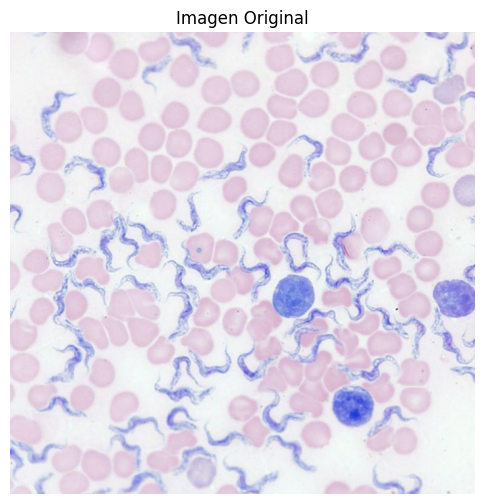

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# --- Configuración de parámetros ---
IMG_PATH = 'ImagenMicroscopiaColor.png'

# Parámetros para el clustering
C = 4                # Número de clusters (p.ej., fondo, 2 tipos de células, parásitos)
M = 2.0              # Parámetro de "fuzziness" (m > 1)
MAX_ITER = 10       # Máximo de iteraciones
EPSILON = 1e-5       # Criterio de parada (tolerancia)

# Parámetros para el ruido
Ruido_MEAN = 0.0
Ruido_SIGMA = 25.0   # Ruido Gausiano

# Parámetros para sFCM (ver PDF, Ecuación 5)
P = 1.0              # Control de la membresía original
Q = 1.0              # Control de la influencia espacial

# --- Cargar la imagen ---
# Leemos la imagen. cv2 la carga en formato BGR.
img_bgr = cv2.imread(IMG_PATH)

# La convertimos a RGB para mostrarla correctamente con matplotlib
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# Normalizamos la imagen a [0, 1] para los cálculos
# Es crucial convertir a float32 ANTES de dividir
img_norm = img_rgb.astype(np.float32) / 255.0

print(f"Imagen cargada con dimensiones: {img_norm.shape}")

# Mostrar la imagen original
plt.figure(figsize=(6, 6))
plt.title("Imagen Original")
plt.imshow(img_norm)
plt.axis('off')
plt.show()

### 2. Incorporación de Ruido Gausiano

Añadimos ruido Gausiano $N(0, \sigma)$ a cada canal de color (R, G, B) de forma independiente.

El ruido se genera con `np.random.normal` y se suma a la imagen normalizada. También nos aseguramos de que los valores resultantes permanezcan en el rango válido [0, 1] usando `np.clip`.

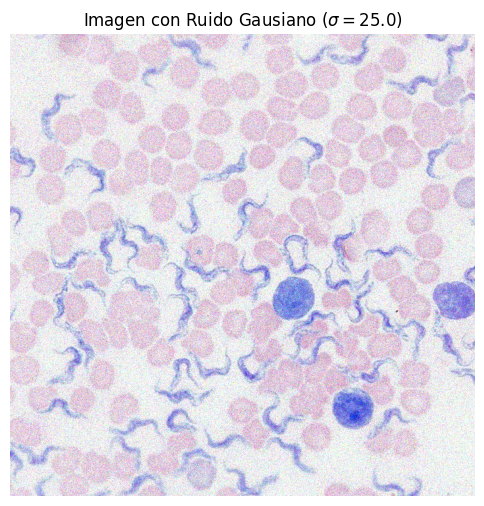

In [11]:
def aplica_ruido_gausiano(imagen, mean=0.0, sigma=1.0):
    """
    Añade ruido Gausiano a cada canal de una imagen.
    
    Args:
        imagen (np.array): Imagen de entrada (H, W, C) normalizada a [0, 1].
        mean (float): Media del ruido.
        sigma (float): Desviación estándar del ruido (en escala 0-255).
    
    Returns:
        np.array: Imagen con ruido, en rango [0, 1].
    """
    # Escalamos sigma al rango [0, 1]
    sigma_norm = sigma / 255.0
    
    # Generamos el ruido Gausiano con las mismas dimensiones que la imagen
    ruido = np.random.normal(mean, sigma_norm, imagen.shape)
    
    # Sumamos el ruido a la imagen
    imagen_ruidosa = imagen + ruido
    
    # Nos aseguramos de que los valores sigan en el rango [0, 1]
    imagen_ruidosa_clip = np.clip(imagen_ruidosa, 0.0, 1.0)
    
    return imagen_ruidosa_clip.astype(np.float32)

# Aplicamos el ruido a nuestra imagen
img_ruido = aplica_ruido_gausiano(img_norm, Ruido_MEAN, Ruido_SIGMA)

# Mostrar la imagen con ruido
plt.figure(figsize=(6, 6))
plt.title(f"Imagen con Ruido Gausiano ($\sigma={Ruido_SIGMA}$)")
plt.imshow(img_ruido)
plt.axis('off')
plt.show()

### 3. Preparación de los Datos para Clustering

Los algoritmos de FCM trabajan sobre un conjunto de **vectores de características**. En nuestro caso, cada píxel es un vector de 3 dimensiones (R, G, B).

Debemos "aplanar" la imagen, convirtiendo nuestra matriz 3D (Alto, Ancho, 3 Canales) en una matriz 2D (Nº Píxeles, 3 Canales).

In [12]:
def preparacion_datos(imagen):
    """
    Convierte una imagen (H, W, C) en una matriz 2D (N_pixels, C).
    
    Args:
        imagen (np.array): Imagen de entrada (H, W, C).
        
    Returns:
        np.array: Datos aplanados (H*W, C).
        tuple: Dimensiones originales (H, W).
    """
    shape_original = imagen.shape
    H, W, C = shape_original
    
    # Reshape: (H, W, C) -> (H * W, C)
    # Cada fila es un píxel, cada columna es una característica (R, G, o B)
    data = imagen.reshape((H * W, C))
    
    return data, (H, W)

# Preparamos los datos de la imagen ruidosa
data_ruido, shape_original = preparacion_datos(img_ruido)
H, W = shape_original
N_PIXELS = data_ruido.shape[0]

print(f"Datos preparados para clustering:")
print(f"  - Píxeles totales (N): {N_PIXELS}")
print(f"  - Características por píxel (Dimensiones): {data_ruido.shape[1]}")

Datos preparados para clustering:
  - Píxeles totales (N): 494906
  - Características por píxel (Dimensiones): 3


### 4. Implementación de Fuzzy C-Means (FCM) desde Cero

Implemento el algoritmo FCM basándonos en el procedimiento descrito en el notebook:

1.  **Inicialización**: Elegimos $c$ centroides $\mu_i$ aleatoriamente.
2.  **Bucle Iterativo**: Repetimos hasta la convergencia (o `MAX_ITER`).
    a.  **Calcular Matriz de Pertenencia $U$**: Para cada píxel $x_k$ y cada clúster $i$, calculamos el grado de pertenencia $u_{ik}$. La fórmula clave es:
        $$u_{ik} = \left( \sum_{j=1}^{c} \left[ \frac{d_{ik}}{d_{jk}} \right]^{\frac{2}{m-1}} \right)^{-1}$$
        Donde $d_{ik} = \|x_k - \mu_i\|^2$ es la distancia Euclídea al cuadrado entre el píxel $k$ y el centroide $i$.

    b.  **Actualizar Centroides $\mu$**: Recalculamos la posición de cada centroide $i$ como la media ponderada (difusa) de todos los píxeles:
        $$\mu_{i} = \frac{\sum_{k=1}^{n} (u_{ik})^m \cdot x_k}{\sum_{k=1}^{n} (u_{ik})^m}$$

3.  **Criterio de Parada**: El bucle termina si el cambio en la matriz de membresía $U$ entre una iteración y la siguiente es menor que `EPSILON`.

In [13]:
def inicializa_centroides(data, C):
    """
    Inicializa C centroides eligiendo C puntos aleatorios de los datos.
    """
    # Obtenemos N índices aleatorios únicos del conjunto de datos
    indices = np.random.choice(data.shape[0], C, replace=False)
    centroides = data[indices, :]
    return centroides.astype(np.float32)


def calcula_pertenencia_fcm(data, centroides, M):
    """
    Calcula la matriz de pertenencia U.
    """
    N_pixeles = data.shape[0]
    N_clusters = centroides.shape[0]
    
    U = np.zeros((N_pixeles, N_clusters), dtype=np.float32)
    
    # 1. Calcular la matriz de distancias (al cuadrado)
    # (Usamos broadcasting de numpy para eficiencia)
    # data shape: (N, D) -> (N, 1, D)
    # centroids shape: (C, D) -> (1, C, D)
    # dist shape: (N, C)
    dist_sq = np.sum((data[:, np.newaxis, :] - centroides[np.newaxis, :, :])**2, axis=2)
    
    # Añadimos un valor muy pequeño para evitar división por cero
    # si un píxel coincide exactamente con un centroide
    dist_sq = np.fmax(dist_sq, 1e-9)
    
    # 2. Calcular U usando la fórmula de FCM
    exponente = 2.0 / (M - 1.0)
    
    # (dist_ik / dist_jk) ^ exponent
    # (N, C, 1) / (N, 1, C) -> (N, C, C)
    dist_ratio = dist_sq[:, :, np.newaxis] / dist_sq[:, np.newaxis, :]
    dist_ratio_pow = np.power(dist_ratio, exponente)
    
    # sum_j( ... )
    sum_over_j = np.sum(dist_ratio_pow, axis=2)
    
    # 1 / sum_j( ... )
    U = 1.0 / sum_over_j
    
    # Normalizamos U para que la suma por filas sea 1 (aunque ya debería serlo)
    # U = U / np.sum(U, axis=1, keepdims=True)
    
    return U, dist_sq

def actualiza_centroides_fcm(data, U, M):
    """
    Actualiza los centroides.
    """
    # U^m
    Um = np.power(U, M)
    
    # Denominador: sum_k(U_ik^m) para cada i
    # (N, C) -> (C,)
    denominador = np.sum(Um, axis=0)
    
    # Numerador: sum_k(U_ik^m * x_k) para cada i
    # (N, C)T * (N, D) -> (C, D)
    numerador = np.dot(Um.T, data)
    
    # μ_i = Numerador / Denominador
    # (C, D) / (C, 1)
    nuevos_centroides = numerador / denominador[:, np.newaxis]
    
    return nuevos_centroides.astype(np.float32)

def fuzzy_c_means(data, C, M, max_iter, epsilon):
    """
    Ejecuta el algoritmo FCM completo.
    """
    print(f"Iniciando FCM (C={C}, M={M})...")
    
    # 1. Inicializar centroides
    centroides = inicializa_centroides(data, C)
    
    # 2. Bucle iterativo
    U = np.zeros((data.shape[0], C), dtype=np.float32)
    
    for i in range(max_iter):
        # Guardamos la U anterior para comprobar la convergencia
        U_old = U.copy()
        
        # 3. Calcular nueva matriz U
        U, _ = calcula_pertenencia_fcm(data, centroides, M)

        print(U)
        
        # 4. Actualizar centroides
        centroides = actualiza_centroides_fcm(data, U, M)
        
        # 5. Comprobar criterio de parada
        diff = np.max(np.abs(U - U_old))
        if diff < epsilon:
            print(f"FCM convergió en la iteración {i+1}.")
            break
    else:
        print(f"FCM alcanzó el máximo de iteraciones ({max_iter}).")
        
    return centroides, U

### 5. Ejecución de FCM y Visualización

Ahora ejecutamos el algoritmo FCM sobre la imagen ruidosa.

Para visualizar el resultado, "defuzzificamos" la imagen: asignamos a cada píxel el clúster (color) para el cual tiene el mayor grado de membresía (el $\mu_i$ correspondiente).

Iniciando FCM (C=4, M=2.0)...
[[0.02008978 0.0532408  0.89628106 0.03038833]
 [0.06789856 0.17488103 0.648082   0.10913838]
 [0.03167892 0.06865233 0.8595694  0.04009938]
 ...
 [0.16684645 0.1632156  0.5821507  0.08778723]
 [0.2008507  0.15773578 0.5408868  0.10052675]
 [0.688901   0.10005111 0.14164029 0.06940755]]
[[0.00666156 0.00934012 0.98106647 0.00293187]
 [0.05850809 0.21864882 0.6693985  0.05344458]
 [0.00984741 0.01139356 0.9750336  0.00372538]
 ...
 [0.164375   0.07751088 0.7332403  0.02487379]
 [0.11251012 0.07112475 0.7947209  0.02164422]
 [0.8119052  0.05781904 0.10831039 0.02196531]]
[[6.2057534e-03 7.8617539e-03 9.8484957e-01 1.0828794e-03]
 [7.2531946e-02 4.9194345e-01 4.0696988e-01 2.8554669e-02]
 [5.8734603e-03 5.8978465e-03 9.8734319e-01 8.8545552e-04]
 ...
 [1.5154053e-01 4.6084102e-02 7.9410118e-01 8.2741454e-03]
 [1.1572522e-01 7.1093768e-02 8.0438042e-01 8.8006295e-03]
 [8.8813394e-01 3.1985920e-02 7.2907060e-02 6.9730980e-03]]
[[7.90841319e-03 1.05387382e-02 9.

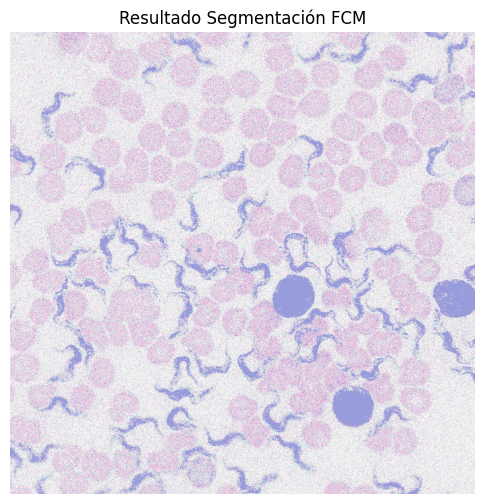


Centroides (colores) encontrados por FCM (RGB [0-1]):
[[0.8034302  0.9001403  0.89095855]
 [0.9150165  0.748736   0.8725498 ]
 [0.9608664  0.94766724 0.9501683 ]
 [0.6014705  0.613043   0.8549304 ]]


In [14]:
def defuzzify_image(data, centroides, U, shape_original):
    """
    Crea la imagen segmentada asignando cada píxel al clúster
    con la membresía más alta (np.argmax).
    """
    H, W = shape_original
    
    # 1. Encontrar el índice del clúster con max(U) para cada píxel
    etiquetas = np.argmax(U, axis=1)
    # 2. Crear la nueva imagen usando los centroides (colores)
    datos_segmentados = centroides[etiquetas]
    # 3. Reshape de vuelta a la forma de imagen (H, W, 3)
    imagen_segmentada = datos_segmentados.reshape((H, W, datos_segmentados.shape[1]))
    
    return imagen_segmentada.astype(np.float32)


# --- Ejecutar FCM ---
fcm_centroides, fcm_U = fuzzy_c_means(data_ruido, C, M, MAX_ITER, EPSILON)

# --- Generar Imagen Segmentada ---
fcm_imagen_segmentada = defuzzify_image(data_ruido, fcm_centroides, fcm_U, shape_original)

# Mostrar el resultado de FCM
plt.figure(figsize=(6, 6))
plt.title("Resultado Segmentación FCM")
# Hacemos clip por si los centroides cayeron ligeramente fuera de [0, 1]
plt.imshow(np.clip(fcm_imagen_segmentada, 0, 1))
plt.axis('off')
plt.show()

print("\nCentroides (colores) encontrados por FCM (RGB [0-1]):")
print(fcm_centroides)

### 6. Implementación de Spatial FCM (sFCM) desde Cero

Modificamos FCM para incluir información espacial.

El algoritmo es un proceso de dos pasos *dentro* de cada iteración:

1.  **Paso 1 (FCM Estándar)**: Calculamos la matriz de membresía $U$ basada en la intensidad/color, exactamente igual que en FCM (la llamaremos $U_{fcm}$).

2.  **Paso 2 (Información Espacial)**:
    a.  Se define una **función espacial $h_{ij}$**  que suma las membresías de los *vecinos* de un píxel $j$ al clúster $i$:
        $$h_{ij} = \sum_{k \in NB(x_j)} U_{ik}$$
        Donde $NB(x_j)$ es una vecindad (ej. $3 \times 3$) alrededor del píxel $j$. Usaremos la $U_{fcm}$ calculada en el Paso 1 para esto.

    b.  La membresía $U$ se actualiza incorporando $h$ :
        $$U'_{ij} = \frac{(U_{fcm})_{ij}^{p} \cdot h_{ij}^{q}}{\sum_{k=1}^{c} (U_{fcm})_{kj}^{p} \cdot h_{kj}^{q}}$$
        Donde $p$ y $q$ controlan la importancia de la intensidad ($U_{fcm}$) y el espacio ($h$).

3.  **Actualización de Centroides**: Usamos esta nueva $U'_{ij}$ (la membresía espacialmente ponderada) para calcular los nuevos centroides, igual que en el FCM estándar.

In [17]:
def calculo_funcion_espacial(U, H, W, N_clusters):
    """
    Calcula la función espacial h usando convolución.
    """
    # 1. Creamos el kernel de vecindad (3x3)
    kernel = np.ones((3, 3), dtype=np.float32)
    
    # 2. Reshape U (N_pixels, C) -> (C, N_pixels) -> (C, H, W)
    U_maps = U.T.reshape((N_clusters, H, W))
    
    h_maps = np.zeros_like(U_maps)
    
    # 3. Aplicamos la convolución a cada mapa de clúster
    for i in range(N_clusters):
        # convolve2d suma los valores de U_maps[i] en la vecindad definida por el kernel
        h_maps[i] = convolve2d(U_maps[i], kernel, mode='same', boundary='symm')
        
    # 4. Reshape de vuelta a (C, N_pixels) -> (N_pixels, C)
    h = h_maps.reshape((N_clusters, H * W)).T
    
    return h.astype(np.float32)


def spatial_fuzzy_c_means(data, C, M, P, Q, H, W, max_iter, epsilon):
    """
    Ejecuta el algoritmo sFCM completo (FCM + Info Espacial).
    """
    print(f"Iniciando sFCM (C={C}, M={M}, P={P}, Q={Q})...")
    
    N_pixels = data.shape[0]
    
    # 1. Inicializar centroides
    centroides = inicializa_centroides(data, C)
    
    # 2. Bucle iterativo
    U_spatial = np.zeros((N_pixels, C), dtype=np.float32)
    
    for i in range(max_iter):
        U_spatial_antiguo = U_spatial.copy()
        
        # --- PASO 1 (FCM Estándar) ---
        # Calcular la membresía U_fcm basada solo en la intensidad/color
        U_fcm, _ = calcula_pertenencia_fcm(data, centroides, M)
        
        # --- PASO 2 (Información Espacial) ---
        # a. Calcular la función espacial h (Ecuación 4)
        # Usamos U_fcm como entrada para h, como sugiere el artículo
        h = calculo_funcion_espacial(U_fcm, H, W, C)
        
        # b. Calcular la nueva membresía U_spatial (Ecuación 5)
        # Numerador: (U_fcm)^p * h^q
        numerador_spatial = np.power(U_fcm, P) * np.power(h, Q)
        
        # Denominador: sum_k( (U_fcm_k)^p * h_k^q )
        # (N, C) -> (N, 1)
        denominador_spatial = np.sum(numerador_spatial, axis=1, keepdims=True)
        
        # Evitar división por cero
        denominador_spatial = np.fmax(denominador_spatial, 1e-9)
        
        U_spatial = numerador_spatial / denominador_spatial
        
        # 3. Actualizar Centroides
        centroides = actualiza_centroides_fcm(data, U_spatial, M)
        
        # 4. Comprobar criterio de parada
        diff = np.max(np.abs(U_spatial - U_spatial_antiguo))
        if diff < epsilon:
            print(f"sFCM convergió en la iteración {i+1}.")
            break
    else:
        print(f"sFCM alcanzó el máximo de iteraciones ({max_iter}).")
            
    return centroides, U_spatial

### 7. Ejecución de sFCM y Comparación Final

Finalmente, ejecutamos sFCM y comparamos los tres resultados: la imagen ruidosa original, la segmentación con FCM estándar y la segmentación con sFCM.

Esperamos que sFCM produzca regiones más homogéneas y elimine gran parte del ruido (píxeles aislados mal clasificados) que FCM no pudo corregir.

Iniciando sFCM (C=4, M=2.0, P=1.0, Q=1.0)...
sFCM alcanzó el máximo de iteraciones (10).


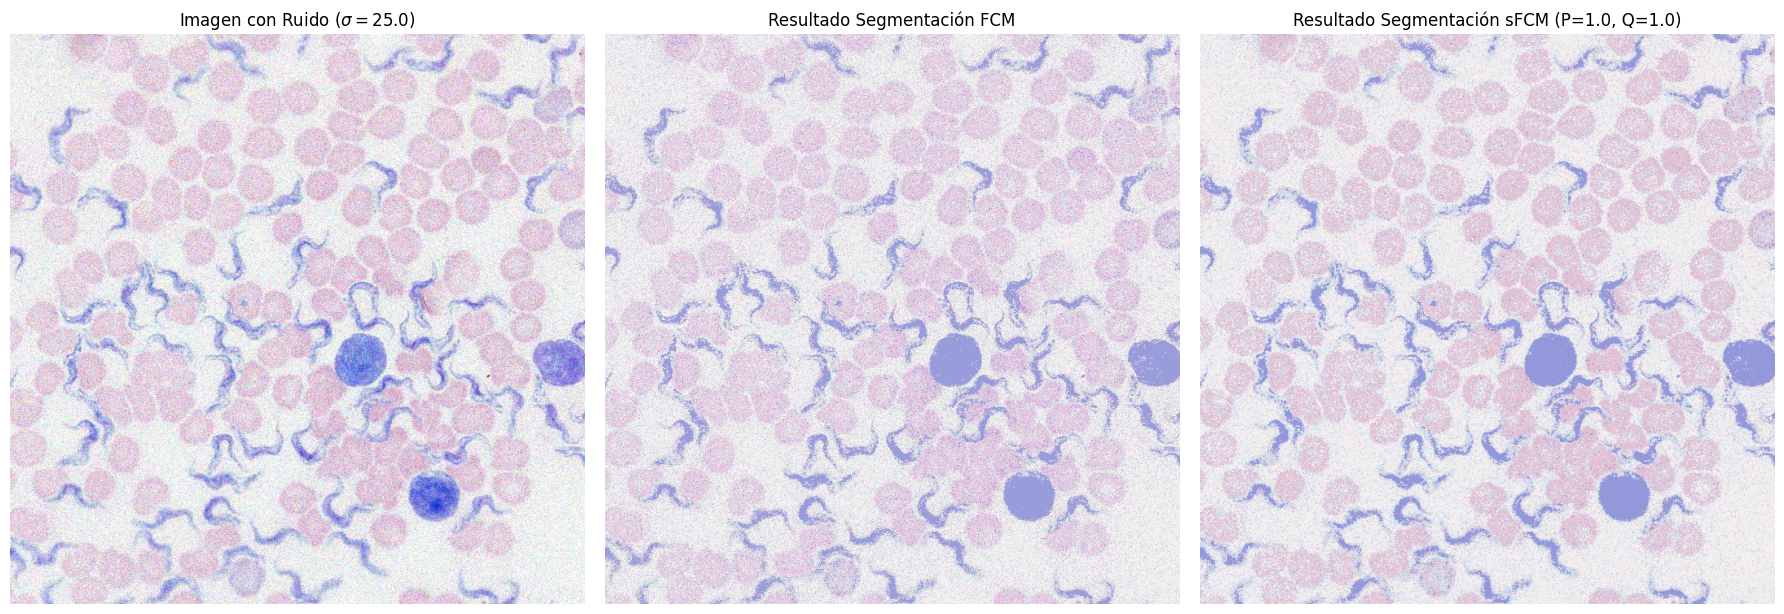


Centroides (colores) encontrados por sFCM (RGB [0-1]):
[[0.95952094 0.93663496 0.93757856]
 [0.57892466 0.5970285  0.85490835]
 [0.89045244 0.75179553 0.8322561 ]
 [0.7951618  0.8852483  0.93658155]]


In [16]:
# --- Ejecutar sFCM ---
# (H y W fueron obtenidos en la Celda 6)
sfcm_centroides, sfcm_U = spatial_fuzzy_c_means(
    data_ruido, C, M, P, Q, H, W, MAX_ITER, EPSILON
)

# --- Generar Imagen Segmentada ---
sfcm_imagen_segmentada = defuzzify_image(data_ruido, sfcm_centroides, sfcm_U, shape_original)

# --- Comparación Final ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Imagen Ruidosa
axes[0].imshow(img_ruido)
axes[0].set_title(f"Imagen con Ruido ($\sigma={Ruido_SIGMA}$)")
axes[0].axis('off')

# Resultado FCM
axes[1].imshow(np.clip(fcm_imagen_segmentada, 0, 1))
axes[1].set_title("Resultado Segmentación FCM")
axes[1].axis('off')

# Resultado sFCM
axes[2].imshow(np.clip(sfcm_imagen_segmentada, 0, 1))
axes[2].set_title(f"Resultado Segmentación sFCM (P={P}, Q={Q})")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("\nCentroides (colores) encontrados por sFCM (RGB [0-1]):")
print(sfcm_centroides)